In [ ]:
using Plots, StatsPlots
using Random
using Distributions
using StatsBase
using KernelDensity
using Trapz

In [ ]:
S_vec = [[parse(Int,c) for c in l] for l in readlines("rec.txt")]

In [ ]:
O = 1:52
plot(O, st=:scatter, legend=false)

In [ ]:
"""
Take an ordered vector O and shuffle it according to the shuffle sequence s.
O: 52 length vector (eg 1:52)
S: 52 length vector of 1 and 2 (eg [1,1,2,1,2,2,1,2,1,2,2,1...])
    1 comes from the bottom ~half of O and are shuffled in with the left hand
    2 comes from the top ~half of O and are shuffled in with the right hand
"""
function shuffle(O,S)
    n2s = sum(S.==2)
    rh = O[1:n2s]
    lh = O[n2s+1:end]
    nd = []
    for s in S
        if s == 1
            push!(nd, popfirst!(lh))
        elseif s==2
            push!(nd, popfirst!(rh))
        else
            error("Only 1s and 2s in S")
        end
    end
    nd
end

In [ ]:
function score_shuffle(S)
    score = 1
    for i in 2:52
        if S[i] != S[i-1]
            score += 1
        end
    end
    score
end

In [ ]:
scores = score_shuffle.(S_vec)
plot(scores, st=:scatter, legend=false, smooth=true,
    xlabel="Row", ylabel="Score")
# savefig("f1.svg")

In [ ]:
O = collect(1:52)
rng = MersenneTwister(1234)

ns = 7

p = [plot(O, st=:scatter, legend = false)]

for i in 1:ns
    S = rand(S_rec)
    O = shuffle(O,S)
    push!(p, plot(O, st=:scatter, legend = false, smooth=true))
end

push!(p, plot(randperm(rng,52), color=:red, st=:scatter, legend = false, smooth=true))

plot(p..., layout = (ns+2, 1), size=(300,2000))

My shuffle model

Reasonable model might be split w/ binomial distrib, then drop with likelihood proportional to number of cards left?
What about "chunks" at top and bottom?

In [ ]:
S_vec

In [ ]:
# Investigate split
split_vec = [count(s.==1) for s in S_vec]
histogram(split_vec, bins=16.5:1:35.5, xticks=17:35, normalize=:pdf, label="observed")

plot!(D, st=:sticks, marker=true, xlims=(17,35), label = "expected (binomial)")
plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases")
# savefig("split_hist.svg")

In [ ]:
# Investigate split
split_vec = [count(s.==1) for s in S_vec]
histogram(split_vec, bins=15.5:1:36.5, xticks=16:36, normalize=:pdf, label="observed", alpha=0.5)

x = [count(split_vec.==val)/100 for val in 16:36]

plot!(16:36, x, st=:sticks, marker=true, xlims=(16,36), label = "Measured Histogram model")
plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases")
savefig("hist_model.svg")

In [ ]:
# Investigate end chunks
println("Fraction that starts with 2: ", count([s[1]   for s in S_rec].==2)/length(S_rec))
println("Fraction that ends with 2: "  , count([s[end] for s in S_rec].==2)/length(S_rec))

A = []
Z = []
for S in S_rec
    e = S[1]
    push!(A,0)
    for s in S
        if s == e
            A[end]+=1
        else
            break
        end
    end
    
    e = S[end]
    push!(Z,0)
    for s in reverse(S)
        if s == e
            Z[end]+=1
        else
            break
        end
    end
end

plot(A,  label="Start", st=:hist, bins=0.5:7.5, lw=2, alpha=0.5, norm=:pdf)
plot!(Z, label="End",   st=:hist, bins=0.5:7.5, lw=2, alpha=0.5, norm=:pdf,
    xlabel="Number of same side cards in a row",
    ylabel="Fraction")


In [152]:
function gsr_shuffle()
    cut = rand(Binomial(52),1)[1]
    nl = cut
    nr = 52 - cut

    out = zeros(Int,52)
    for i in 1:52
        pl = nl / (nl + nr)
        if rand() < pl
            out[i] = 1
            nl -= 1
        else
            out[i] = 2
            nr -= 1
        end
    end

    out
end

gsr_shuffle (generic function with 1 method)

In [155]:
GSR_vec = [gsr_shuffle() for _ in 1:10000]

10000-element Vector{Vector{Int64}}:
 [2, 1, 1, 1, 1, 2, 2, 2, 1, 1  …  1, 1, 2, 2, 1, 2, 2, 1, 2, 2]
 [1, 1, 1, 2, 2, 1, 2, 1, 1, 1  …  2, 1, 2, 2, 1, 2, 2, 2, 1, 1]
 [1, 1, 1, 2, 2, 2, 2, 1, 1, 2  …  1, 1, 1, 2, 1, 2, 1, 1, 2, 2]
 [1, 2, 1, 1, 2, 2, 1, 2, 1, 2  …  2, 1, 1, 1, 1, 1, 1, 2, 2, 2]
 [1, 1, 1, 1, 2, 2, 2, 2, 1, 1  …  2, 2, 1, 1, 2, 2, 1, 2, 2, 2]
 [1, 2, 2, 2, 2, 1, 2, 2, 2, 1  …  1, 1, 1, 1, 1, 2, 2, 2, 2, 1]
 [2, 1, 2, 1, 1, 1, 2, 2, 2, 1  …  2, 2, 1, 2, 2, 2, 2, 1, 2, 2]
 [2, 2, 1, 2, 1, 1, 2, 1, 1, 1  …  2, 2, 2, 1, 2, 1, 1, 2, 2, 2]
 [2, 2, 1, 2, 2, 1, 1, 1, 1, 1  …  1, 2, 1, 2, 1, 1, 2, 1, 1, 2]
 [2, 1, 2, 1, 1, 2, 2, 1, 2, 1  …  1, 1, 1, 2, 1, 2, 1, 2, 2, 2]
 ⋮
 [2, 2, 2, 1, 1, 2, 2, 1, 1, 1  …  2, 1, 1, 2, 1, 1, 1, 2, 2, 2]
 [2, 1, 1, 2, 2, 2, 1, 1, 1, 2  …  2, 1, 1, 1, 1, 1, 1, 1, 2, 2]
 [2, 1, 2, 2, 2, 1, 2, 1, 2, 2  …  1, 2, 2, 2, 2, 1, 2, 2, 1, 2]
 [1, 2, 2, 1, 2, 1, 1, 1, 2, 2  …  1, 2, 2, 2, 2, 2, 1, 2, 2, 2]
 [1, 2, 1, 1, 1, 2, 1, 2, 2, 1  …  2, 1, 1, 2, 2, 

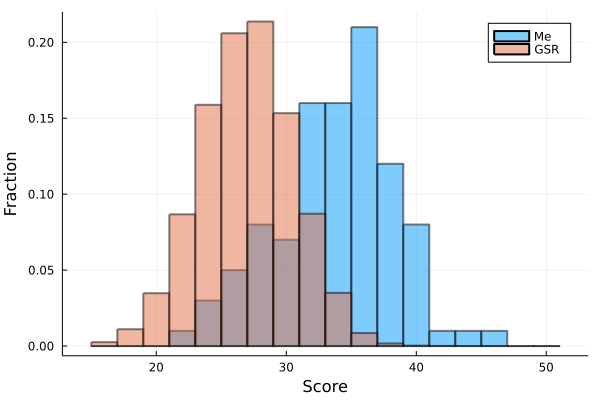

In [156]:
S_scores = score_shuffle.(S_vec)
GSR_scores = score_shuffle.(GSR_vec)
histogram(scores,      label="Me",  bins=15:2:52, lw=2, alpha=0.5, norm=:probability)
histogram!(GSR_scores, label="GSR", bins=15:2:52, lw=2, alpha=0.5, norm=:probability,
    xlabel="Score", ylabel="Fraction")
# savefig("score_comp_hist.svg")

In [ ]:
mean(GSR_scores)

In [ ]:
distributions = [   Bernoulli
                    Beta
                    Binomial
                    Categorical
                    DiscreteUniform
                    Exponential
                    LogNormal
                    Normal
                    Gamma
                    Geometric
                    Laplace
                    Pareto
                    Poisson
                    Rayleigh
                    InverseGaussian
                    Uniform
                    Weibull]



In [ ]:
distributions = [   
    (Exponential,       "Exponential")
    (LogNormal,         "LogNormal")
    (Normal,            "Normal")
    (Gamma,             "Gamma")
    (Laplace,           "Laplace")
    (Pareto,            "Pareto")
    (Poisson,           "Poisson")
    (Rayleigh,          "Rayleigh")
    (InverseGaussian,   "InverseGaussian")
    (Uniform,           "Uniform")
    (Weibull,           "Weibull")
]

histogram(split_vec, bins=15.5:36.5, norm=:pdf, label="observed", alpha=0.5)

for d in distributions
    f = fit_mle(d[1], split_vec)
    f = truncated(f,16,36)
    plot!(f, st=:line, label = d[2], lw=2)
end
plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases", xlims=(16,36), xticks=16:36)
savefig("all_continuous.svg")

In [ ]:
distributions = [   
    # (Bernoulli,         "Bernoulli")
    # (Beta,              "Beta")
    # (Binomial,          "Binomial")
    # (Categorical,       "Categorical")
    # (DiscreteUniform,   "DiscreteUniform")
    # (Exponential,       "Exponential")
    (LogNormal,         "LogNormal")
    (Normal,            "Normal")
    (Gamma,             "Gamma")
    # (Geometric,         "Geometric")
    # (Laplace,           "Laplace")
    # (Pareto,            "Pareto")
    # (Poisson,           "Poisson")
    # (Rayleigh,          "Rayleigh")
    (InverseGaussian,   "InverseGaussian")
    # (Uniform,           "Uniform")
    # (Weibull,           "Weibull")
]

histogram(split_vec, bins=15.5:36.5, norm=:pdf, label="observed", alpha=0.5)


for d in distributions
    f = fit_mle(d[1], split_vec)
    f = truncated(f,16,36)

    #Integrate
    x_ep = 15.5:36.5
    x_cp = 16:36
    y_cp = [cdf(f, x_ep[i+1]) - cdf(f, x_ep[i]) for i in 1:length(x_ep)-1]

    plot!(x_cp, y_cp, st=:line, label = d[2], lw=2)
end
plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases", xlims=(16,36), xticks=16:36)

savefig("few_continuous.svg")

In [ ]:
d_full  = fit_mle(Normal, split_vec)
d_trunc = truncated(d_full, 16,36)

In [ ]:
[println(val, ": ", count(split_vec.==val)) for val in 16:36]

In [ ]:
split_vec = [count(s.==1) for s in S_vec]
histogram(split_vec, bins=15.5:36.5, norm=:pdf, label="observed", alpha=0.5)

f = fit_mle(Binomial, 52, split_vec)
f = truncated(f,16,36)
plot!(f, st=:line, label = "Binomial(52)", lw=2)

x = 16:36
f = fit_mle(Binomial, x[end]-x[1], split_vec.-x[1])
plot!(x, st=:line, pdf.(f, x.-x[1]), label = "Binomial(20)", lw=2)

distributions = [   
    (DiscreteUniform,   "DiscreteUniform")
    (Geometric,         "Geometric")
    (Poisson,           "Poisson")
]
for d in distributions
    f = fit_mle(d[1], split_vec)
    f = truncated(f,16,36)
    plot!(f, st=:line, marker=false, label = d[2], lw=2)
end
plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases", xlims=(16,36), xticks=16:36)
savefig("discrete_fits.svg")

In [ ]:
1 - 0.3895

In [ ]:
histogram(split_vec, bins=15.5:36.5, norm=:pdf, label="observed", alpha=0.5)
for bw = [0.2, 0.5, 1.0, 2.0]
    k = kde(split_vec, boundary=(26-10, 26+10), bandwidth=bw)
    
    x = 16:0.01:36
    y = pdf(k, x)

    x_ep = 15.5:36.5
    x_cp = 16:36
    y_cp = [trapz(x[(x.>x_ep[i]) .& (x.<x_ep[i+1])], y[(x.>x_ep[i]) .& (x.<x_ep[i+1])]) for i in 1:length(x_ep)-1]
    
    plot!(x_cp, y_cp, lw=2, label="BW = " * string(bw))
end

plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases", xlims=(16,36), xticks=16:36)

savefig("kernel_fit.svg")

In [ ]:
histogram(split_vec, bins=15.5:36.5, norm=:pdf, label="observed", alpha=0.5)

x = [count(split_vec.==val)/100 for val in 1:52]
plot!(x, st=:line, label = "Measured Histogram", lw=2)

x = 16:36
f = fit_mle(Binomial, x[end]-x[1], split_vec.-x[1])
plot!(x, st=:line, pdf.(f, x.-x[1]), label = "Binomial(20)", lw=2)

f = fit_mle(Normal, split_vec)
f = truncated(f,16,36)
x_ep = 15.5:36.5
x_cp = 16:36
y_cp = [cdf(f, x_ep[i+1]) - cdf(f, x_ep[i]) for i in 1:length(x_ep)-1]
plot!(x_cp, y_cp, st=:line, label = "Normal", lw=2)

k = kde(split_vec, boundary=(26-10, 26+10), bandwidth=0.5)
x = 16:0.01:36
y = pdf(k, x)
x_ep = 15.5:36.5
x_cp = 16:36
y_cp = [trapz(x[(x.>x_ep[i]) .& (x.<x_ep[i+1])], y[(x.>x_ep[i]) .& (x.<x_ep[i+1])]) for i in 1:length(x_ep)-1]
plot!(x_cp, y_cp, st=:line, label = "KDE w/ BW=0.5", lw=2)

plot!(xlabel="Number of Cards in Left Hand", ylabel="Fraction of Cases", xlims=(16,36), xticks=16:36)

savefig("4best.svg")

In [ ]:
f = fit_mle(Normal, split_vec)

In [ ]:
# Investigate split
rec_gsr = [sum(s.==1) for s in GSR_rec]
histogram(rec_gsr, bins=12.5:1:39.5, xticks=13:39, label="observed", normalize=:pdf)
plot!(Binomial(52), st=:line, xlims=(12,40), label = "binomial")

In [ ]:
# Investigate end chunks
println("Fraction that starts with 2: ", count([s[1]   for s in GSR_rec].==2)/length(GSR_rec))
println("Fraction that ends with 2: "  , count([s[end] for s in GSR_rec].==2)/length(GSR_rec))

A = []
Z = []
for S in GSR_rec
    e = S[1]
    push!(A,0)
    for s in S
        if s == e
            A[end]+=1
        else
            break
        end
    end
    
    e = S[end]
    push!(Z,0)
    for s in reverse(S)
        if s == e
            Z[end]+=1
        else
            break
        end
    end
end

plot(A,  label="Start", st=:hist, bins=0.5:9.5, lw=2, alpha=0.5, norm=:pdf)
plot!(Z, label="End",   st=:hist, bins=0.5:9.5, lw=2, alpha=0.5, norm=:pdf,
    xlabel="Number of same side cards in a row",
    ylabel="Fraction",
    xticks = 1:9)


In [ ]:
# What's my brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in S_vec
    for (i,s) in enumerate(S)
        nl = count(S[1:i].==2)
        nr = count(S[1:i].==1)
        prob = nl/(nl+nr)
        outc = (s == 2)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

In [ ]:
edges = 0:0.1:1.0
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)

outF = Float64[]
for i in 1:length(binC)
    idx = binindices .== i
    push!(outF, count(outcs[idx]) / count(idx))
end

In [ ]:
scatter(binC, outF, label="Actual", legend=:topleft, xlims=(0,1), ylims=(0,1))
plot!(binC, binC, label="Perfectly Calibrated")

In [ ]:
# What's my brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in S_vec
    for (i,s) in enumerate(S)
        nl = count(S[i:end].==1)
        nr = count(S[i:end].==2)
        prob = nl/(nl+nr)
        outc = (s == 1)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

edges = 0.0:0.1:1.0
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)


outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .> 39)
    push!(outF, count(outcs[idx]) / count(idx))
end
p = plot(binC, outF, markershape=:circle, label="Actual, cards 1-13", xlims=(-0.03,1.03), ylims=(-0.03,1.03))

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .> 13 .& cards .< 40)
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, markershape=:circle, label="Actual, cards 14-39")

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) .& (cards .< 14)
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, markershape=:circle, label="Actual, cards 1-13")

outF = Float64[]
for i in 1:length(binC)
    idx = (binindices .== i) 
    push!(outF, count(outcs[idx]) / count(idx))
end
plot!(p, binC, outF, color=:black, label="Actual, all")


plot!(p, binC, binC, label="Perfectly Calibrated", legend=:bottomright)

# save("test.png",p)
p

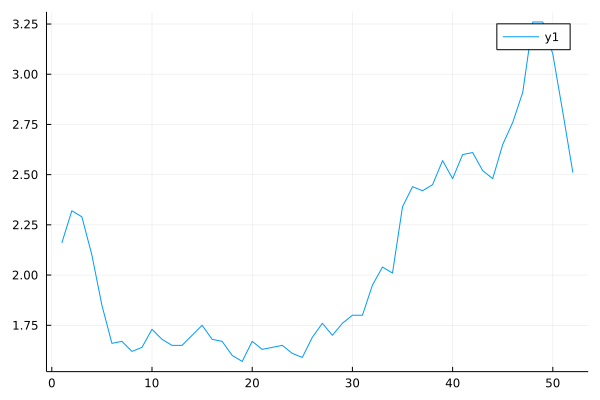

In [172]:
#Chance a card is in a run? - show EV run length and chance left/right
run_rec = []
for S in S_vec
    this_run_rec = ones(Int,52)
    current_run_idx = falses(52)
    current_run_idx[1] = true
    current_run_len = 1
    for i in 2:52
        if S[i] == S[i-1]
            current_run_idx[i] = true
            current_run_len += 1
            this_run_rec[current_run_idx] .= current_run_len
        else
            current_run_len = 1
            current_run_idx .= false
            current_run_idx[i] = true
        end
    end
    push!(run_rec, this_run_rec)
end

run_rec
run_ev = [mean([s[i] for s in run_rec]) for i in 1:52]
plot(run_ev)

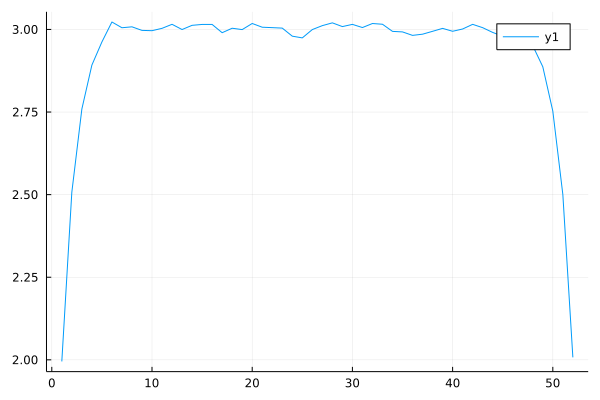

In [181]:
run_rec = []
for S in GSR_vec
    this_run_rec = ones(Int,52)
    current_run_idx = falses(52)
    current_run_idx[1] = true
    current_run_len = 1
    for i in 2:52
        if S[i] == S[i-1]
            current_run_idx[i] = true
            current_run_len += 1
            this_run_rec[current_run_idx] .= current_run_len
        else
            current_run_len = 1
            current_run_idx = falses(52)
            current_run_idx[i] = true
        end
    end
    push!(run_rec, this_run_rec)
end

run_rec
run_ev = [mean([s[i] for s in run_rec]) for i in 1:52]
plot(run_ev)

In [185]:
sum([i / 2^i for i in 1:15])

1.999481201171875

In [186]:
sum([i / 2^(i+1) for i in 0:15])

0.9997406005859375

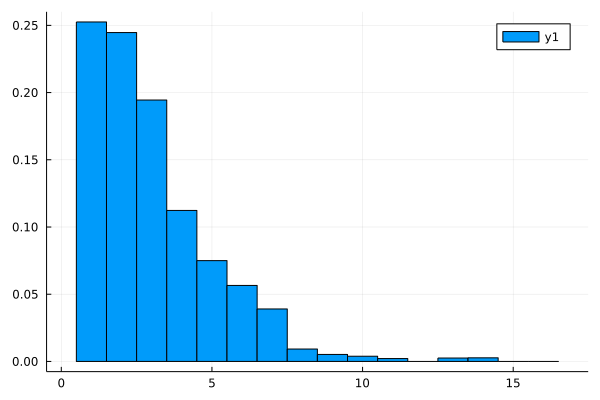

In [178]:
histogram(vcat(run_rec...), bins = 0.5:1:16.5, norm=:pdf)

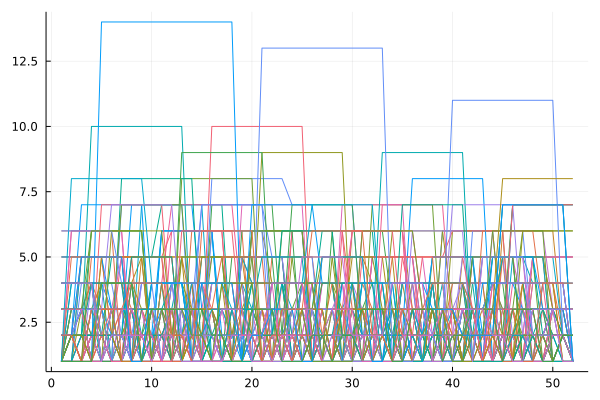

In [179]:
plot(run_rec, label=false)

In [160]:
side_ev = [mean([s[i] for s in S_vec]) for i in 1:52] .- 1
plot(side_ev, label="observed", ylims=(0, 1), ylabel="← Left Hand                Right Hand →", xlabel="Card Number", lw=2)

GSR_side_ev = [mean([s[i] for s in GSR_vec]) for i in 1:52] .- 1
plot!(GSR_side_ev, label="GSR model", lw=2)

savefig("side_expected.svg")

In [ ]:
side_ev = 2 .* ([mean([s[i] for s in GSR_rec]) for i in 1:52] .- 1.5)
plot(side_ev, ylims = (-1, 1))

In [ ]:
scatter(probs)

In [165]:
# What's my brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in S_vec
    for (i,s) in enumerate(S)
        nl = count(S[i:end].==1)
        nr = count(S[i:end].==2)
        prob = nl/(nl+nr)
        outc = (s == 1)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

edges = 0:0.1:1.0
edges = collect(edges)
edges[end] = 1.0001
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)

outF = Float64[]
dps  = Int[]
for i in 1:length(binC)
    idx = binindices .== i
    push!(outF, count(outcs[idx]) / count(idx))
    push!(dps, count(idx))
end

X = vcat([[x-0.05,x-0.05,x+0.05,x+0.05,x-0.05,NaN] for x in binC]...)
Y = vcat([[x-0.05,x+0.05,x+0.05,x-0.05,x-0.05,NaN] for x in binC]...)
plot(X, Y, fill=true, label="Perfectly Calibrated", aspect_ratio=1, size=(500,500),
    xlabel = "Predicted Probability",
    ylabel = "Observed Probability",
    xticks = 0:0.1:1, yticks=0:0.1:1)

outF[dps.<10] .= 0
dps[dps.<10]  .= 0
binX = [mean(probs[binindices.==i]) for i in 1:length(dps)]
scatter!(binX, outF, markersize=log.(dps/maximum(dps)).+9, label="Actual", legend=:topleft, xlims=(-0.05,1.05), ylims=(-0.05,1.05))

savefig("my_calibration.svg")

In [ ]:
dps

In [ ]:
# What's GSR brier? Split up into 1/4 of deck to see where I'm good and bad
probs = Float64[]
outcs = Bool[]
cards = Int[]
for S in GSR_rec
    for (i,s) in enumerate(S)
        nl = count(S[1:i].==2)
        nr = count(S[1:i].==1)
        prob = nl/(nl+nr)
        outc = (s == 2)
        push!(probs, prob)
        push!(outcs, outc)
        push!(cards, nl+nr)
    end
end

edges = 0:0.1:1.0
binC  = 0.05:0.1:0.95

h  = fit(Histogram, probs, edges)
binindices = StatsBase.binindex.(Ref(h), probs)

outF = Float64[]
dps  = Int[]
for i in 1:length(binC)
    idx = binindices .== i
    push!(outF, count(outcs[idx]) / count(idx))
    push!(dps, count(idx))
end


X = vcat([[x,x,NaN] for x in binC]...)
Y = vcat([[x-0.05,x+0.05,NaN] for x in binC]...)
X = vcat([[x-0.05,x-0.05,x+0.05,x+0.05,x-0.05,NaN] for x in binC]...)
Y = vcat([[x-0.05,x+0.05,x+0.05,x-0.05,x-0.05,NaN] for x in binC]...)

plot(X, Y, fill=true, label="Perfectly Calibrated", aspect_ratio=1, size=(500,500),
    xlabel = "Predicted Probability",
    ylabel = "Observed Probability",
    xticks = binC, yticks=binC)

scatter!(binC, outF, markersize=log.(dps/maximum(dps)).+10, label="Actual", legend=:topleft, xlims=(-0.05,1.05), ylims=(-0.05,1.05))


Show 3 Draw 1 advantage (using ML models?)

Premo

In [ ]:
O0 = collect(1:52)
O1 = shuffle(O0, gsr_shuffle())
O2 = shuffle(O1, gsr_shuffle())
O3 = shuffle(O2, gsr_shuffle())
scatter(O3)

In [ ]:
function rising_sequences(Oin)
    
    O = copy(Oin)

    rseq = []
    c_seq = Int[]
    seq_class = zeros(Int,52)
    i = 1
    val = 1

    while val < 53

        if i > length(O)
            i = 1
            push!(rseq, c_seq)
            c_seq = Int[]
        end

        if O[i] == val
            push!(c_seq, popat!(O,i))
            seq_class[Oin .== val] .= length(rseq) + 1
            val += 1
            continue
        else
            i+=1
        end
        
    end

    push!(rseq, c_seq)
    
    return rseq, seq_class
end



In [ ]:
rs, sq = rising_sequences(O1)
scatter(O1, color=sq, legend = false)


In [ ]:
rs, sq = rising_sequences(O2)
scatter(O2, color=sq, legend = false)

In [ ]:
rs, sq = rising_sequences(O3)
scatter(O3, color=sq, legend = false)

In [ ]:
O0 = collect(1:52)
O1 = shuffle(O0, gsr_shuffle())
O2 = shuffle(O1, gsr_shuffle())
O3 = shuffle(O2, gsr_shuffle())
tc = O3[1]
Opremo = insert!(O3[2:end], rand(1:52), O3[1])
rs, sq = rising_sequences(Opremo)

sl = [length(s) for s in rs]
ss = argmin(sl)
ssl = sl[ss]


println("Top card actual: ", tc)
if ssl == 1
    println("Top card guess: ", rs[ss][1])
else
    println("Can't guess")
end

scatter(Opremo, color=sq, legend = false)


In [ ]:
argmin([length(s) for s in rs])

In [ ]:
rs